### Text Generation from image
###### By Kruti Thukral (012586041)
###### Reference paper
Show and Tell: A Neural Image Caption Generator
Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan; The IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2015, pp. 3156-3164

Reference code snippet 
- https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

As per the paper, a simple encoder-decoder architecture composed of a CNN and RNN can be used to generate text from an image. 

Youtube link for individual project presentation and project details
- https://www.youtube.com/watch?v=y9f2BcCA-Xo&feature=youtu.be

Github link for project implementation
- https://github.com/kruti-thukral/image_captioning

Dataset can be downloaded from https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

- Datasets that need to be downloaded from above link are 
- Flickr8k_Dataset.zip
- Flickr8k_text.zip

Pre-trained Glove embeddings can be downloaded from 
- https://nlp.stanford.edu/projects/glove/
- glove.6B.zip from above link was used in the project


In [2]:
# Use unzip utility to unzip the flickr8k dataset. Run only once and is required when data is available in zipped format
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/image_captioning/Flickr8k_Dataset.zip", 'r')
# specify extraction path
zip_ref.extractall("/content/drive/My Drive/image_captioning/final1")
zip_ref.close()



'\n# Use unzip utility to unzip the flickr8k dataset. Run only once and is required when data is available in zipped format\nimport zipfile\nfrom google.colab import drive\n\ndrive.mount(\'/content/drive/\')\n\nzip_ref = zipfile.ZipFile("/content/drive/My Drive/image_captioning/Flickr8k_Dataset.zip", \'r\')\n# specify extraction path\nzip_ref.extractall("/content/drive/My Drive/image_captioning/final1")\nzip_ref.close()\n'

In [3]:
# import required libraries
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from google.colab import drive
# Remount google drive to access the flickr8k 





Using TensorFlow backend.


In [4]:
# remount to access extracted folder. Not required if data was available in unzipped format
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
# utility to load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# the folder path will have to be updated as per the folder structure 
root_dataset = "/content/drive/My Drive/image_captioning/"
root_flickr_text = "/content/drive/My Drive/image_captioning/Flickr8k_text/"
root_flickr_image = "/content/drive/My Drive/image_captioning/final1/Flicker8k_Dataset/"
filename = root_flickr_text + "/Flickr8k.token.txt"

# load captions for images
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [6]:
# Below path contains all the images
images = root_flickr_image
#!ls "/content/drive/My Drive/image_captioning/Flickr8k_Dataset/"
print(images)
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
print(len(img))

/content/drive/My Drive/image_captioning/final1/Flicker8k_Dataset/
8091


In [7]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [8]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [12]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [14]:
## Some Exploratory data analysis
# creating corpus
corpus = ""

for ec in descriptions.values():
    for el in ec:
        corpus += " "+el

total_words = corpus.split()
#vocabulary_for_EDA = set(total_words)
print("The number of words in the corpus {}".format(len(total_words)))
from nltk import FreqDist

freq_dist = FreqDist(total_words)
freq_dist.most_common(10)


The number of words in the corpus 372935


[('in', 18975),
 ('the', 18419),
 ('on', 10744),
 ('is', 9345),
 ('and', 8852),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7266),
 ('of', 6713),
 ('two', 5639)]

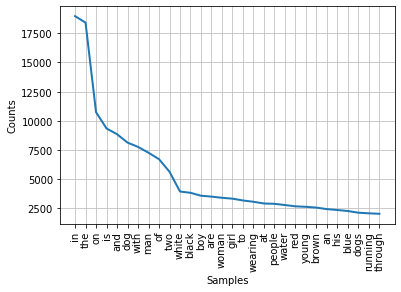

In [15]:
# plot words with the most frequency
freq_dist.plot(30)

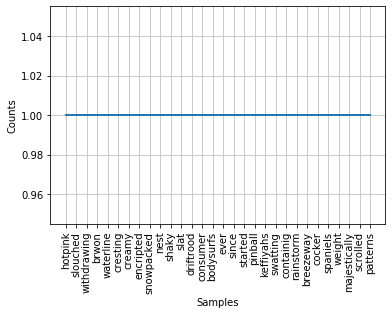

In [16]:
# plot words with the least frequency

least_common = FreqDist(dict(freq_dist.most_common()[-30:]))
least_common.plot()

In [17]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, root_dataset + 'descriptions.txt')

In [19]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = root_flickr_text + 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = root_flickr_text + 'Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = root_flickr_text + 'Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [22]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(root_dataset + 'descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [24]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')














96116736/96112376 [==============================] - 3s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [27]:

# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
print(len(train_img))
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)


'\n# Call the funtion to encode all the train images\n# This will take a while on CPU - Execute this only once\nstart = time()\nencoding_train = {}\nprint(len(train_img))\nfor img in train_img:\n    encoding_train[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)\n'

In [28]:

# Save the bottleneck train features to disk
root_flickr_pickle = root_dataset + "pickle/"
print(encoding_train)
with open(root_flickr_pickle + "encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)


'\n# Save the bottleneck train features to disk\nroot_flickr_pickle = root_dataset + "pickle/"\nprint(encoding_train)\nwith open(root_flickr_pickle + "encoded_train_images.pkl", "wb") as encoded_pickle:\n    dump(encoding_train, encoded_pickle)\n'

In [29]:

# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

'\n# Call the funtion to encode all the test images - Execute this only once\nstart = time()\nencoding_test = {}\nfor img in test_img:\n    encoding_test[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)\n'

In [30]:

# Save the bottleneck test features to disk
with open(root_flickr_pickle + "encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)


'\n# Save the bottleneck test features to disk\nwith open(root_flickr_pickle + "encoded_test_images.pkl", "wb") as encoded_pickle:\n    dump(encoding_test, encoded_pickle)\n'

In [33]:
root_flickr_pickle = root_dataset + "pickle/"
train_features = load(open(root_flickr_pickle + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [34]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [35]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [37]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [38]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [40]:
# Load Glove vectors

glove_dir = root_dataset
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [42]:
embedding_matrix.shape

(1652, 200)

In [43]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [45]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
epochs = 10

In [53]:
root_model_weights = root_dataset + "model_weights/"
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(root_model_weights + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 912s 456ms/step - loss: 4.1402
Epoch 1/1
2000/2000 [==============================] - 926s 463ms/step - loss: 3.4331
Epoch 1/1
2000/2000 [==============================] - 933s 466ms/step - loss: 3.2095
Epoch 1/1
2000/2000 [==============================] - 944s 472ms/step - loss: 3.0766
Epoch 1/1
2000/2000 [==============================] - 962s 481ms/step - loss: 2.9827
Epoch 1/1
2000/2000 [==============================] - 973s 486ms/step - loss: 2.9074
Epoch 1/1
2000/2000 [==============================] - 966s 483ms/step - loss: 2.8525
Epoch 1/1
2000/2000 [==============================] - 969s 484ms/step - loss: 2.8051
Epoch 1/1
2000/2000 [==============================] - 970s 485ms/step - loss: 2.7647
Epoch 1/1
2000/2000 [==============================] - 966s 483ms/step - loss: 2.7335


In [0]:
model.save_weights(root_model_weights + 'model_10.h5')

In [0]:
model.load_weights(root_model_weights + 'model_10.h5')

In [0]:
images = root_flickr_image

In [0]:
with open(root_flickr_pickle + "encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
# utility to predict caption using greedy search
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

The image vector for test images is available in encoding_test and can be accessed using an index. Lets check the predicted captions for the test images. 

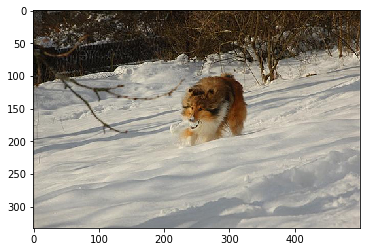

Greedy: dog runs through the grass


In [59]:
z = 0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

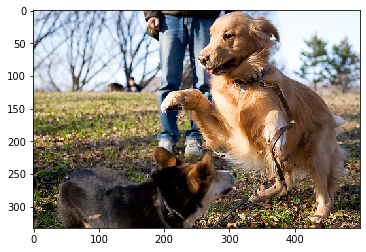

Greedy: two dogs play together in the grass


In [60]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

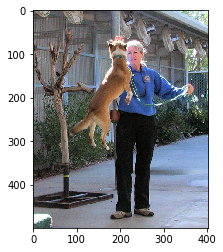

Greedy: man in black shirt is standing on the sidewalk


In [61]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

2


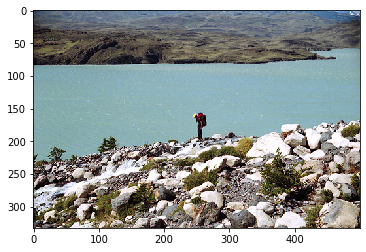

Greedy: man is standing on top of mountain overlooking the water


In [62]:
print(z)
z+=1
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [63]:
print(encoding_test.keys())

dict_keys(['384577800_fc325af410.jpg', '387830531_e89c192b92.jpg', '391579205_c8373b5411.jpg', '396360611_941e5849a3.jpg', '398662202_97e5819b79.jpg', '400851260_5911898657.jpg', '401079494_562454c4d6.jpg', '405615014_03be7ef618.jpg', '410453140_5401bf659a.jpg', '415793623_6c1225ae27.jpg', '416106657_cab2a107a5.jpg', '416788726_5b4eb1466e.jpg', '416960865_048fd3f294.jpg', '421322723_3470543368.jpg', '421730441_6b2267fd31.jpg', '422763475_0bc814dac6.jpg', '424416723_19c56cb365.jpg', '424779662_568f9606d0.jpg', '429851331_b248ca01cd.jpg', '430173345_86388d8822.jpg', '434792818_56375e203f.jpg', '435827376_4384c3005a.jpg', '436009777_440c7679a1.jpg', '439037721_cdf1fc7358.jpg', '444057017_f1e0fcaef7.jpg', '444481722_690d0cadcf.jpg', '447111935_5af98563e3.jpg', '448252603_7d928c900e.jpg', '448658518_eec0b648a6.jpg', '452419961_6d42ab7000.jpg', '460935487_75b2da7854.jpg', '461505235_590102a5bf.jpg', '463978865_c87c6ca84c.jpg', '464251704_b0f0c4c87a.jpg', '466956209_2ffcea3941.jpg', '46810226

3


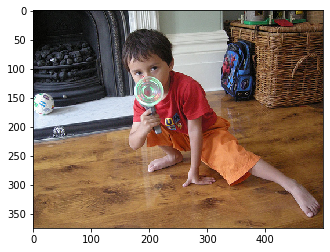

Greedy: toddler is petting on the bed


In [64]:
print(z)
z = 999
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

999


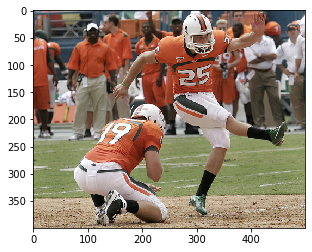

Greedy: two men play football on field


In [65]:
print(z)
z = 500
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

500


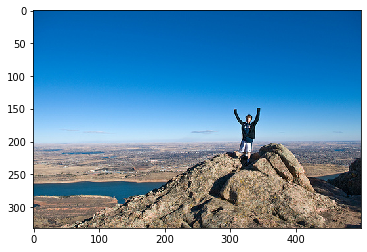

Greedy: man is sitting on top of cliff overlooking the mountains


In [66]:
print(z)
z = 400
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

Not bad predictions ! But we see that some predictions are incorrect. Lets train the model further for 10 epochs to see whether there are improvements in predictions.

In [67]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(root_model_weights + 'model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 973s 486ms/step - loss: 2.7048
Epoch 1/1
2000/2000 [==============================] - 963s 481ms/step - loss: 2.6754
Epoch 1/1
2000/2000 [==============================] - 966s 483ms/step - loss: 2.6550
Epoch 1/1
2000/2000 [==============================] - 992s 496ms/step - loss: 2.6325
Epoch 1/1
2000/2000 [==============================] - 958s 479ms/step - loss: 2.6152
Epoch 1/1
2000/2000 [==============================] - 948s 474ms/step - loss: 2.5982
Epoch 1/1
2000/2000 [==============================] - 947s 474ms/step - loss: 2.5842
Epoch 1/1
2000/2000 [==============================] - 953s 476ms/step - loss: 2.5736
Epoch 1/1
2000/2000 [==============================] - 957s 478ms/step - loss: 2.5602
Epoch 1/1
2000/2000 [==============================] - 957s 478ms/step - loss: 2.5494


In [0]:
model.save_weights(root_model_weights + 'model_20.h5')

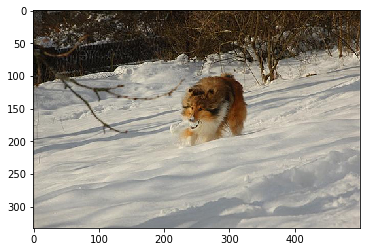

Greedy: dog running through the snow


In [69]:
z = 0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

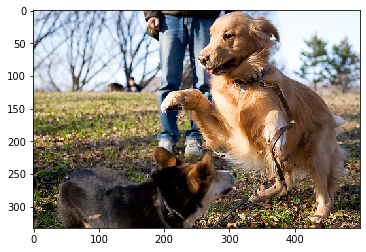

Greedy: two dogs are running through the grass


In [70]:
z += 1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

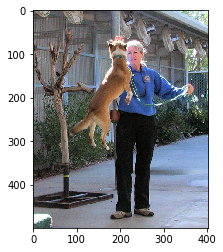

Greedy: man in red shirt is standing on the sidewalk next to woman in white jacket


In [71]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

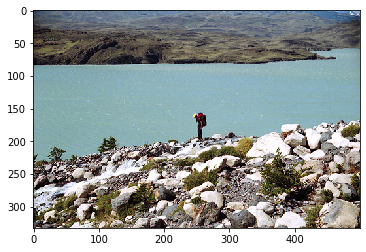

Greedy: man is standing on top of mountain looking at the ocean


In [72]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

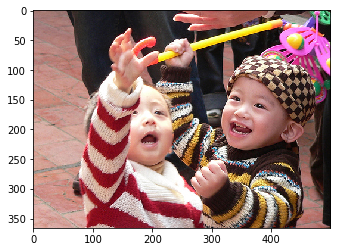

Greedy: little boy is playing with toy stuffed toy


In [73]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

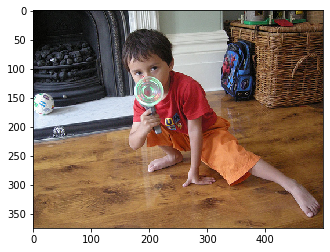

Greedy: man in blue shirt is holding up sign while sitting on the concrete


In [74]:
z = 999
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

999


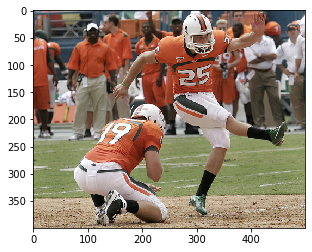

Greedy: two men play ball


In [75]:
print(z)
z = 500
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

500


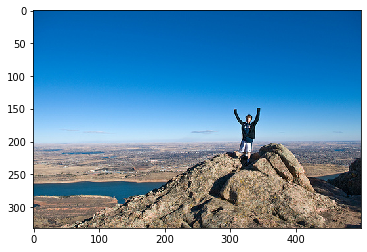

Greedy: man is standing on top of mountain


In [76]:
print(z)
z = 400
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

We see that there is slight improvement in model prediction on further training the model. We can continue this process until we reach the optimal weights for the trainable parameters.

In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [84]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 796s 796ms/step - loss: 2.4833
Epoch 1/1
1000/1000 [==============================] - 792s 792ms/step - loss: 2.4736
Epoch 1/1
1000/1000 [==============================] - 784s 784ms/step - loss: 2.4646
Epoch 1/1
1000/1000 [==============================] - 772s 772ms/step - loss: 2.4545
Epoch 1/1
1000/1000 [==============================] - 767s 767ms/step - loss: 2.4446
Epoch 1/1
1000/1000 [==============================] - 770s 770ms/step - loss: 2.4347
Epoch 1/1
1000/1000 [==============================] - 778s 778ms/step - loss: 2.4267
Epoch 1/1
1000/1000 [==============================] - 779s 779ms/step - loss: 2.4180
Epoch 1/1
1000/1000 [==============================] - 767s 767ms/step - loss: 2.4119
Epoch 1/1
1000/1000 [==============================] - 776s 776ms/step - loss: 2.4038


In [0]:
model.save_weights(root_model_weights + 'model_30.h5')

In [0]:
# add code to generate captions depending on index
z = [0,1,2,3,4,999,500,400, 344, 200, 100, 56, 90, 466, 499, 677, 899, 15]
prediction = []
for i in z:
  item = {}
  pic = list(encoding_test.keys())[i]
  image = encoding_test[pic].reshape((1,2048))
  item['x'] = images+pic
  item['index'] = i
  item['predicted_caption'] = greedySearch(image)
  prediction.append(item)
  


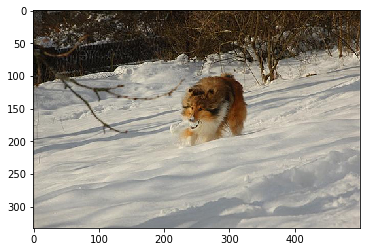

Index:0 Greedy:dog runs through the snow


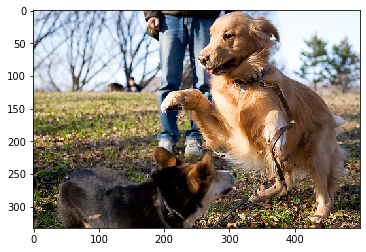

Index:1 Greedy:two dogs are running through the grass


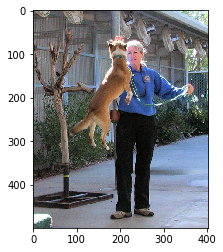

Index:2 Greedy:man in white shirt is standing on the sidewalk next to wire


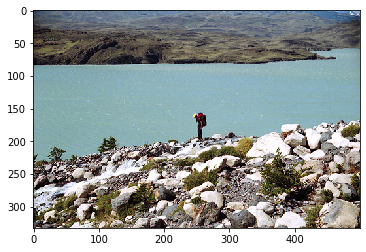

Index:3 Greedy:man stands on top of cliff overlooking mountains


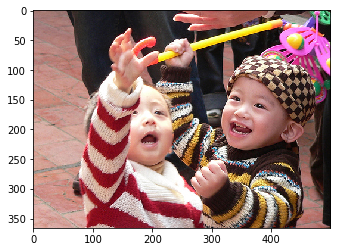

Index:4 Greedy:little girl in pink shirt is laying on the bed with her fingers sticking out


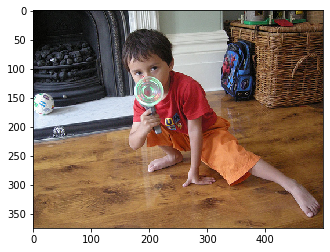

Index:999 Greedy:boy in red shirt is standing on the carpet with his arms raised


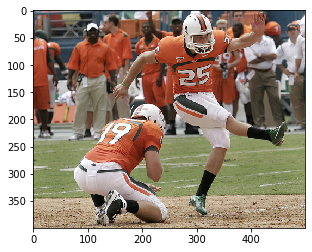

Index:500 Greedy:two football players attempt to get the ball


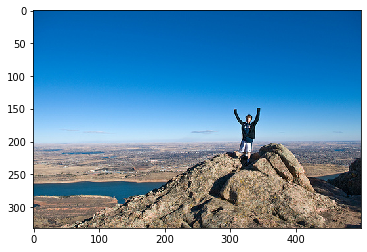

Index:400 Greedy:man stands on top of mountain


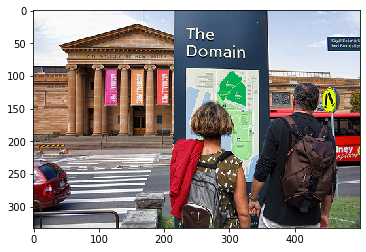

Index:344 Greedy:man in black shirt and tie is standing in front of shop


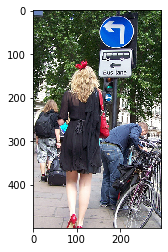

Index:200 Greedy:woman in pink tank top and black jacket walks down street


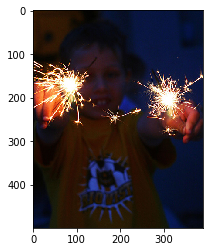

Index:100 Greedy:two girls are putting bubbles which no no of water


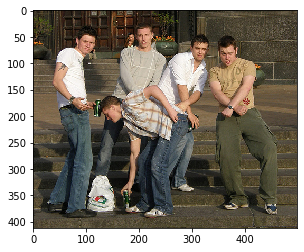

Index:56 Greedy:two women sit on bench in front of lake


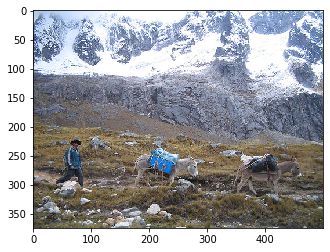

Index:90 Greedy:man in red hat stands on rocky mountain


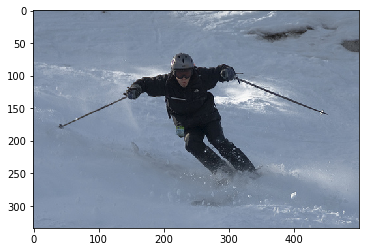

Index:466 Greedy:man skiing down snowy mountain


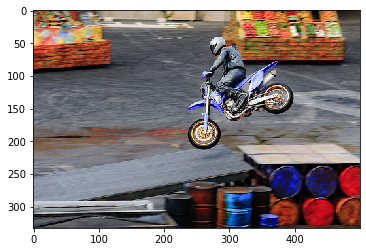

Index:499 Greedy:man riding bike on street lined with houses


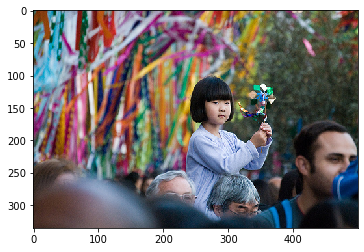

Index:677 Greedy:two girls are playing in the garden


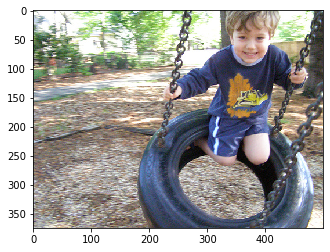

Index:899 Greedy:girl smiles while swinging on swing set


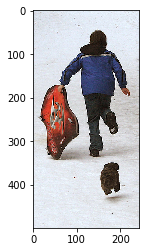

Index:15 Greedy:young girl in red coat is climbing on red slide


In [87]:
for dic in prediction:
    x=plt.imread(dic['x'])
    plt.imshow(x)
    plt.show()
    print("Index:" + str(dic['index']) + " Greedy:" + dic['predicted_caption'])

In [0]:
actual, predicted = list(), list()

In [0]:
for key, feature_list in encoding_test.items():
  
  image = feature_list.reshape((1,2048))
  yhat = greedySearch(image)
  
  image_id = key.split('.')[0]
  desc_list = descriptions[image_id];
  
  references = [d.split() for d in desc_list]
  actual.append(references)
  predicted.append(yhat.split())

In [90]:
print(len(actual))
print(len(predicted))

from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

1000
1000
BLEU-1: 0.438373
BLEU-2: 0.251009
BLEU-3: 0.171954
BLEU-4: 0.079744
